# ⛳ Segmentation map으로 도로 이미지 만들기 ⛳

## 프로젝트 수행
___

프로젝트를 진행하면서 필수로 수행해야 할 사항은 아래와 같다.

1. 데이터에 한 가지 이상의 `augmentation 방법을 적용`하여 학습(어떠한 방법을 사용했는지 기재.)

2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 `U-Net Generator`를 사용

3. 모델 학습 후, 학습된 Generator를 이용해 테스트한다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용.

4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화.

5. 모델을 충분히 학습하기에 시간이 부족할 수 있다. 적어도 10 epoch 이상 학습하며 `중간 손실 값에 대한 로그`를 남기기.

## 1. 데이터 준비하기

In [ ]:
import os

data_path = "/content/drive/MyDrive/AIFFEL/data/conditional_generation/cityscapes/train/"

print("The number of train examples: ", len(os.listdir(data_path)))

The number of train examples:  1000


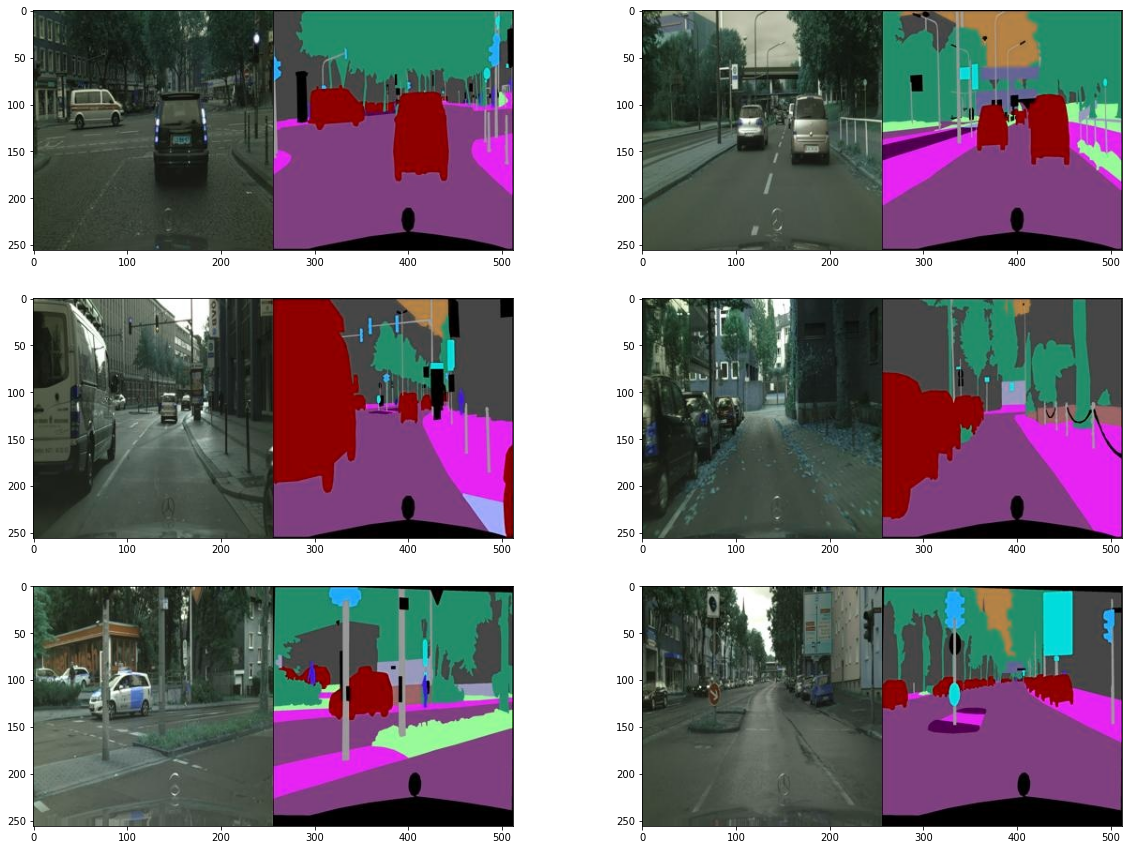

In [ ]:
# 이미지 확인
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)] # 이미지 리스트에서 랜덤
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.imshow(img)

In [ ]:
# 이미지 하나의 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## 2. 이미지 전처리

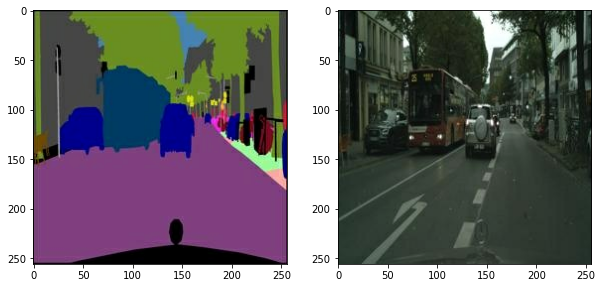

In [ ]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    ground_truth = img[:, :w, :] 
    ground_truth = tf.cast(ground_truth, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(ground_truth)

f = data_path + os.listdir(data_path)[1]
input_image, ground_truth = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(ground_truth))

## 3. Data Augmentation

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용 
def apply_augmentation(input_image, ground_truth):
    # 두 이미지가 채널 축으로 연결 (tf.concat) 두 이미지가 각각 3채널인 경우 6채널이 된다
    stacked = tf.concat([input_image, ground_truth], axis=-1)
    
    # 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad witdth 만큼 적용(tf.pad)
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # (256, 256, 6) 크기를 가진 이미지 임의로 잘라낸다 (tf.image.random_crop)
    out = image.random_crop(padded, size=[256, 256, 6])
    
    # 50% 확률로 가로로 뒤집는다 (tf.image.random_flip_left_right)
    out = image.random_flip_left_right(out)
    # 50% 확률로 세로로 뒤집는다 (tf.image.random_flip_up_down)
    out = image.random_flip_up_down(out)
    
    # 50% 확률로 회전 시킨다(tf.image.rot90)
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

print("Check")

Check


⏳ 데이터에 **apply augmentation** 방법을 적용하여 학습 진행

⏳ 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연사을 두 이미지에 적용

### ▶ augmentation 적용 후 시각화

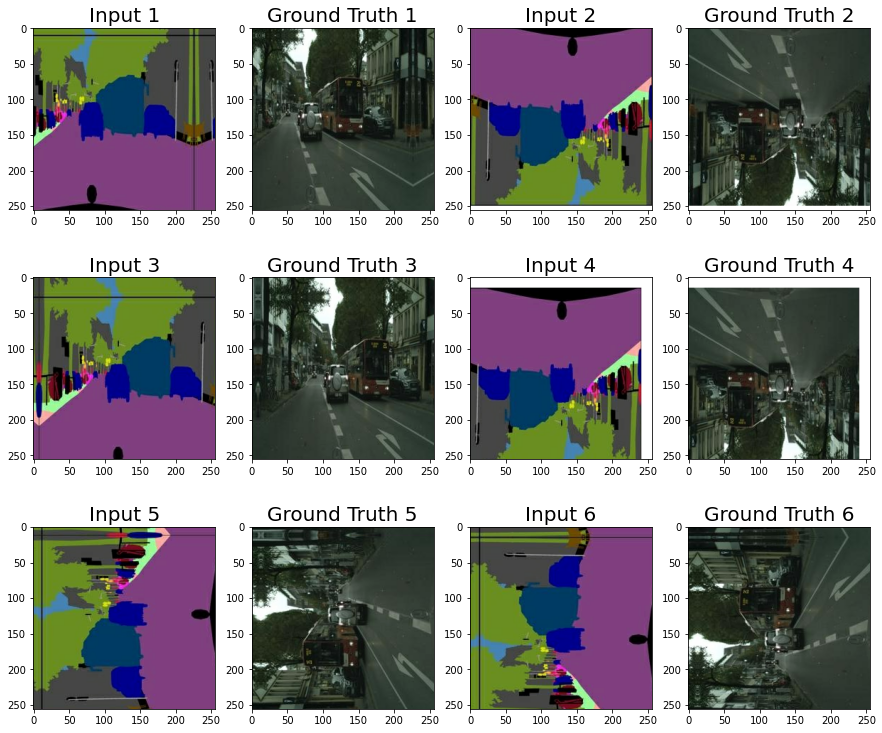

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_input, augmented_gt = apply_augmentation(input_image, ground_truth)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_input)); plt.title(f"Input {img_n}", fontsize=20)
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_gt)); plt.title(f"Ground Truth {img_n}", fontsize=20)
    img_n += 1

### ▶ 적용된 시각화 확인

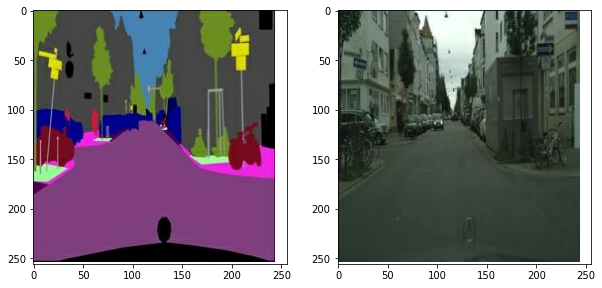

In [ ]:
from tensorflow import data

def get_train(img_path):
    input_image, ground_truth = load_img(img_path)
    input_image, ground_truth = apply_augmentation(input_image, ground_truth)
    return input_image, ground_truth

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_image, ground_truth = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(input_image[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(ground_truth[0].astype(np.uint8))

### 3. Generator 구성

두 개의 Generator 중 Encoder과 Decoder 사이에 skip connection 이 있는 U-Net Generator 를 사용

In [ ]:
from tensorflow.keras import layers, Input, Model

## ▶ Encoder 및 Decoder에 사용되는 기본적인 블록

In [ ]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization(momentum=0.9)
        self.lrelu = layers.LeakyReLU(0.1)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization(momentum=0.9)
        self.relu = layers.ReLU(0.1)
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

print("Check")

Check


### ▶ 정의된 블록들을 이용해 한 번에 U-Net Generator를 정의

In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("Check")

Check


### ▶ U-Net 구조 Generator 내부의 각 출력이 적절한지 확인

In [ ]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

### 4. Discriminator 구성하기

### ▶ Discriminator 기본적인 블록 구현

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization(momentum=0.9) if use_bn else None
        self.lrelu = layers.LeakyReLU(0.1) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x
        
print("Check")

Check


### ▶ Discriminator 만들기

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
  
print("Check")

Check


### ▶ 블록별 출력 크기 확인

In [ ]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

### ▶ 출력 시각화

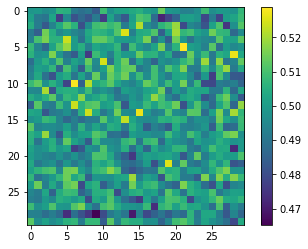

In [ ]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### 5. 학습 및 테스트

### 손실함수 : Generator 및 Discriminator의 손실 계산 정의

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# Loss Function of Generator
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

# Loss Funtion of Discriminator
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)
    
print("Check")

Check


### ▶ 최적화 : 사용할 optimizer 설정

In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("Check")

Check


### ▶ 가중치 업데이트 : 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트

In [ ]:
@tf.function
def train_step(input_image, ground_truth, generator, discriminator):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        gen_output = generator(input_image, training=True)
        # Discriminator 예측
        fake_disc = discriminator(input_image, gen_output, training=True)
        real_disc = discriminator(input_image, ground_truth, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(gen_output, ground_truth, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("Check")

Check


### ▶ 학습 시키기

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/AIFFEL/data/conditional_generation/cityscapes/training_checkpoints"

generator = UNetGenerator()
discriminator = Discriminator()

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
val_path = "/content/drive/MyDrive/AIFFEL/data/conditional_generation/cityscapes/val/"

val_len = len(os.listdir(val_path)) # the number ofvalidation images
print("The number of val examples: ", val_len)

The number of val examples:  5


In [ ]:
def generate_and_save_images(model, epoch, it):
    fig = plt.figure(figsize=(12, 8))

    for i in range(val_len):
        f = val_path + os.listdir(val_path)[i]
        input_image, ground_truth = load_img(f)

        pred = generator(tf.expand_dims(input_image, 0), training=False)
        pred = denormalize(pred)

        plt.subplot(1, 5, i+1)
        plt.imshow(pred[0])
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/AIFFEL/data/conditional_generation/cityscapes/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
import time
from IPython import display 

# history
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

def train(train_images, epochs, save_every, generator, discriminator):
    start = time.time()

    for epoch in range(1, EPOCHS+1):
        epoch_start = time.time()
        for i, (input_image, ground_truth) in enumerate(train_images):
            g_loss, l1_loss, d_loss = train_step(input_image, ground_truth, generator, discriminator)

            history['gen_loss'].append(g_loss)
            history['l1_loss'].append(l1_loss)
            history['disc_loss'].append(d_loss)
                    
            if (i+1) % 50 == 0:
                display.clear_output(wait=False)
                generate_and_save_images(generator, epoch + 1, i + 1)
                print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                        \nGenerator_loss: {g_loss.numpy():.4f} \
                        \nL1_loss: {l1_loss.numpy():.4f} \
                        \nDiscriminator_loss: {d_loss.numpy():.4f} \
                        \nTime for epoch {epoch} : {int(time.time()-epoch_start)} sec", end="\n\n")
                train_time = time.strftime('%H:%M:%S', time.gmtime(int(time.time()-start)))
                print(f'>>>> Time for training: {train_time}', end="\n\n")
                
        if epoch % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix) # save checkpoint

        display.clear_output(wait=False)
        generate_and_save_images(generator, epoch, i)
        train_time = time.strftime('%H:%M:%S', time.gmtime(int(time.time()-start)))
        print(f'>>>> Time for training: {train_time}', end="\n\n")

In [ ]:
EPOCHS = 500
save_every = 5

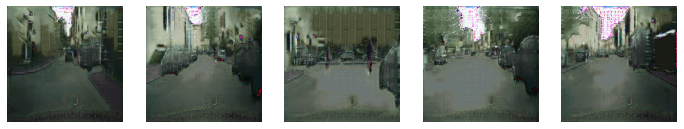

>>>> Time for training: 04:10:43

CPU times: user 3h 54min 28s, sys: 18min 3s, total: 4h 12min 32s
Wall time: 4h 10min 43s


In [24]:
%%time
with tf.device('/GPU:0'):
    train(train_images, EPOCHS, save_every, generator, discriminator)

## 6. 결과

### ▶ history 를 통한 Loss 시각화

In [25]:
def plot_history(history):
    plt.figure(figsize=(16,10))
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

    plt.subplot(311)
    plt.plot(history['gen_loss'])
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.title('Generator Loss', fontsize=20)

    plt.subplot(312) 
    plt.plot(history['l1_loss'])
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.title('L1 Loss', fontsize=20)

    plt.subplot(313)
    plt.plot(history['disc_loss'])
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.title('Discriminator Loss', fontsize=20)
    plt.show()

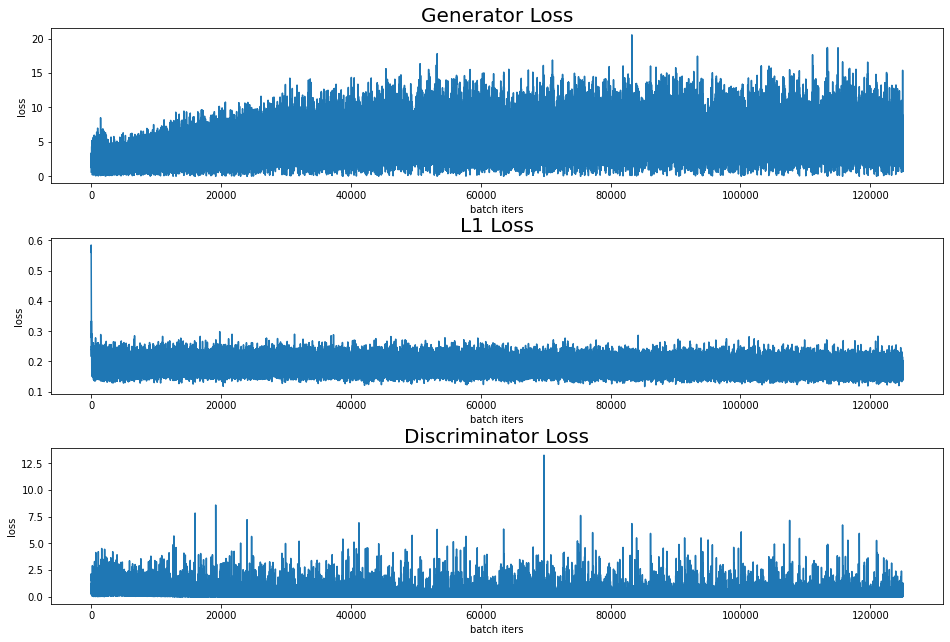

In [26]:
plot_history(history)

⏳ 500 epoch이라는 많은 시간을 투자하여 Loss 는 점차 줄어드는 것으로 확인되었다.

### ▶ gif 변환 시각화

In [27]:
import imageio
import glob

anim_file = '/content/drive/MyDrive/AIFFEL/data/conditional_generation/cityscapes/cityscape.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/AIFFEL/data/conditional_generation/cityscapes/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [30]:
from IPython.display import Image

Image(open(anim_file,'rb').read())

Output hidden; open in https://colab.research.google.com to view.

⏳ gif 를 통하여 학습되어지는 모습이다. (아직 많이 부족한 것 같다)

## ▶ validation data로 이미지 생성

In [28]:
def print_generated_images(n=5):
    for i in range(n):
        f = val_path + os.listdir(val_path)[i] # validataion data images
        input_image, ground_truth = load_img(f)

        pred = generator(tf.expand_dims(input_image, 0))
        pred = denormalize(pred)

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=20)
        plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Generated Image', fontsize=20)
        plt.subplot(1,3,3); plt.imshow(denormalize(ground_truth)); plt.title('Ground Truth', fontsize=20)

In [29]:
print_generated_images()

Output hidden; open in https://colab.research.google.com to view.

⏳ validation data 로 확인 시 gif 로 확인 한 것 보다는 육안으로 식별이 어느정도 가능한 것 같다.